In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [3]:
#plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (cm2inch(19),cm2inch(9))
plotsize_subplots = (16,3)

fontsize_axis = 9
fontsize_labels = 9
fontsize_legends = 8

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

In [4]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_vp"""
    
    # For MAM, T_conns is divided into T_network_global and T_connect:
    if 'T_conns_min' not in list(df) and 'T_network_global_min' in list(df): 
        df['T_conns_min'] = df['T_network_global_min'] + df['T_connect_min']
        df['T_conns_max'] = df['T_network_global_max'] + df['T_connect_max']
    
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():  # Population model
        # Population model does not simulate, VSize_mem is therefore equal to VSize_ini_sum as this is the
        # end of the benchmark
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df):  # MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']  # VSize_mem_sum is called VSize_net_sum for MAM
        df['VSize_nodes_sum'] = np.NaN  # MAM model does not have VSize_nodes_sum

    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)

    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per VP'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3

    return df

In [5]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45, one_row=True, logy=False,
                 color=None, plot_T_sim=True, plot_kind='bar', title=''):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP']
    if not index:
        index='N_VP'
    if plot_T_sim:
        df['Simulation time'] = df['T_sim']
        values.insert(3, 'Simulation time')
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)

    # Make subplots
    if one_row:
        fig, axes = plt.subplots(nrows=1, ncols=len(values))
        if len(values) == 1:
            axes = [axes]
                
        for indx, val_name in enumerate(values):
            df_p[val_name].plot(kind=plot_kind, ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot,
                                logy=logy, legend=False, color=color)
        axes[0].legend(fontsize=fontsize_legends, loc=legend_loc)
        
        plt.subplots_adjust(wspace=0.5)
    else:
        plotsize_subplots = (cm2inch(19),cm2inch(9))
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=plotsize_subplots)

        df_p['Conn. Creation (min)'].plot(kind='bar', ax = axes[0][0], title='Conn. Creation (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        axes[0][0].legend(fontsize=fontsize_legends, loc=legend_loc)
        df_p['Conn. Exchange (min)'].plot(kind='bar', ax = axes[0][1], title='Conn. Exchange (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        df_p['Conn. Total'].plot(kind='bar', ax = axes[1][0], title='Conn. Total', fontsize=fontsize_axis,
                                 rot=rot, legend=False)
        df_p['Memory per VP'].plot(kind='bar', ax = axes[1][1], title='Memory per VP', fontsize=fontsize_axis,
                                   rot=rot, legend=False)

        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # y-axis labels
    if 'Total Conn. Time per Conn.' in values:  
        axes[0].set_ylabel(r'Time [$\mu$s]')  # Not safe..
    else:
        if one_row:
            axes[0].set_ylabel('Time [s]')
        else:
            axes[0][0].set_ylabel('Time [s]')
            axes[1][0].set_ylabel('Time [s]')
    if 'Memory per VP' in values:
        # Assume memory is last entry in values
        if one_row:
            axes[len(values) - 1].set_ylabel('Memory [GiB]')
        else:
            axes[1][1].set_ylabel('Memory [GiB]')
    elif 'Memory per connection' in values:
        axes[len(values) - 1].set_ylabel('Memory [B]')

    # x-axis labels
    if one_row:
        for ax in axes:
            ax.set_xlabel(index)

    if title:
        fig.suptitle(title, y=1.2)
            
    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

# Benchmarks

## SLI Benchmarks

## HPC Benchmark - weak scaling

0    2.531476e+09
1    5.062951e+09
2    1.012590e+10
3    2.025180e+10
4    4.050360e+10
5    8.100720e+10
0    2.531476e+09
1    5.062951e+09
2    1.012590e+10
3    2.025180e+10
4    4.050360e+10
5             NaN
0    2.531476e+09
1    5.062951e+09
2    1.012590e+10
3    2.025180e+10
4    4.050360e+10
5    8.100720e+10
Name: N_conns_sum, dtype: float64

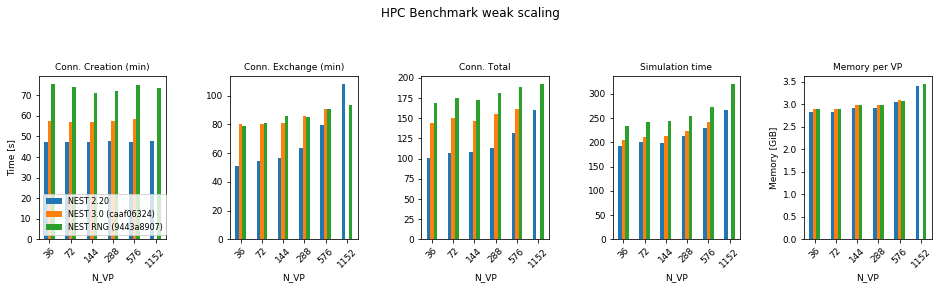

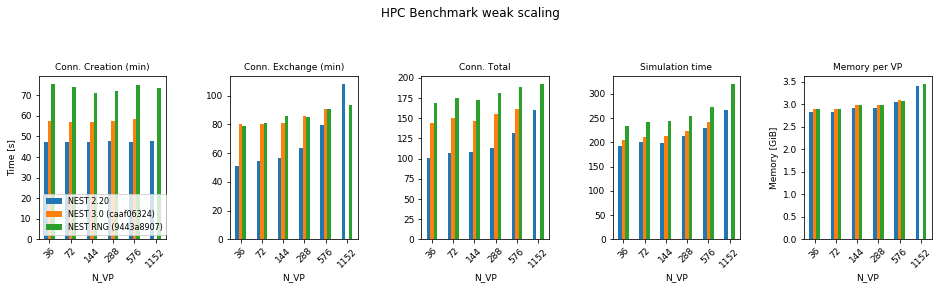

In [19]:
hpc_220 = pd.read_csv('results/hpc_benchmark_2_20_daint.csv')
hpc_220['Case'] = ['NEST 2.20'] * len(hpc_220)

# hpc_3_a6 = pd.read_csv('results/hpc_benchmark_3_0_a641eec1e_daint.csv')
# hpc_3_a6['Case'] = ['NEST 3.0 (a641eec1e)'] * len(hpc_3_a6)
# hpc_3_8f = pd.read_csv('results/hpc_benchmark_3_0_8f5a5fc1e_daint.csv')
# hpc_3_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(hpc_3_8f)
hpc_3_ca = pd.read_csv('results/hpc_benchmark_3_0_caaf06324_daint.csv')
hpc_3_ca['Case'] = ['NEST 3.0 (caaf06324)'] * len(hpc_3_ca)

# hpc_rng = pd.read_csv('results/rng/hpc_benchmark_rng_9443a8907_daint.csv')
# hpc_rng['Case'] = ['NEST RNG (9443a8907)'] * len(hpc_rng)
hpc_rng = pd.read_csv('results/rng/hpc_benchmark_rng_9443a8907_daint.csv')
hpc_rng['Case'] = ['NEST RNG (9443a8907)'] * len(hpc_rng)

hpc = pd.concat([hpc_220, hpc_3_ca, hpc_rng])

hpc = calculate_T_conn_and_memory(hpc)
hpc_p = plot_compare(hpc, 'figures/rng/hpc_benchmark_weak_scaling.pdf', legend_loc='lower left',
                     title='HPC Benchmark weak scaling')
hpc_p = plot_compare(hpc, 'figures/rng/hpc_benchmark_weak_scaling.png', legend_loc='lower left',
                     title='HPC Benchmark weak scaling')

hpc['N_conns_sum']

## HPC Benchmark - strong scaling

Conn. Creation (min)                                            \
Case                 NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                                  
6                         0.61                 0.93                 0.95   
12                        0.30                 0.48                 0.49   
24                        0.15                 0.24                 0.26   
48                        0.08                 0.13                 0.13   
96                        0.04                 0.07                 0.07   
192                       0.02                  NaN                 0.04   
384                       0.01                  NaN                 0.02   
768                       0.00                  NaN                 0.02   

          Conn. Exchange (min)                                            \
Case                 NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                                  
6                         0.68                 1.13                 1.20   
12                        0.47                 0.63                 0.65   
24                        0.31                 0.35                 0.36   
48                        0.29                 0.29                 0.24   
96                        0.16                 0.15                 0.18   
192                       0.18                  NaN                 0.13   
384                       0.20                  NaN                  NaN   
768                       0.18                  NaN                 0.28   

          Conn. Total                                            \
Case        NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                         
6                1.48                 2.31                 2.52   
12               0.80                 1.23                 1.34   
24               0.49                 0.68                 0.76   
48               0.82                 0.50                 0.46   
96               0.61                 0.29                 0.32   
192              0.88                  NaN                 0.21   
384              0.94                  NaN                  NaN   
768              0.71                  NaN                 0.33   

          Memory per task                                            \
Case            NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                             
6                0.635518             1.097183             1.083729   
12               0.540298             0.994475             0.979556   
24               0.461600             0.925828             0.924947   
48               0.760461             1.118091             0.839632   
96               0.372274             0.836309             0.831420   
192              0.346288                  NaN             0.789341   
384              0.348532                  NaN                  NaN   
768              0.347982                  NaN             0.779703   

          Simulation time                                            
Case            NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)  
num_tasks                                                            
6                    6.69                 7.38                 9.11  
12                   3.83                 4.02                 4.84  
24                   2.42                 2.27                 2.67  
48                   8.71                 6.01                 1.74  
96                   2.10                 1.82                 1.75  
192                  2.74                  NaN                 1.78  
384                  3.36                  NaN                  NaN  
768                  3.62                  NaN                 2.23

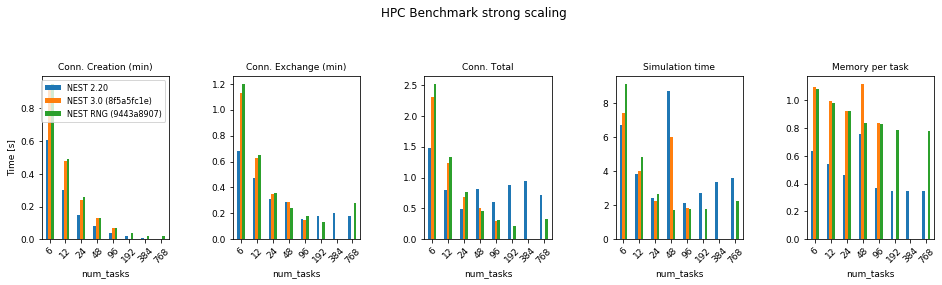

In [23]:
hpc_strong_220 = pd.read_csv('results/hpc_benchmark_2_20_daint_strong_scaling.csv')
hpc_strong_220['Case'] = ['NEST 2.20'] * len(hpc_strong_220)

hpc_3_strong_8f = pd.read_csv('results/hpc_benchmark_3_0_8f5a5fc1e_daint_strong_scaling.csv')
hpc_3_strong_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(hpc_3_strong_8f)

hpc_strong_rng = pd.read_csv('results/rng/hpc_benchmark_rng_9443a8907_daint_strong_scaling.csv')
hpc_strong_rng['Case'] = ['NEST RNG (9443a8907)'] * len(hpc_strong_rng)

hpc_strong = pd.concat([hpc_strong_220, hpc_3_strong_8f, hpc_strong_rng])

hpc_strong = calculate_T_conn_and_memory(hpc_strong)
hpc_strong['Memory per task'] = (hpc_strong['VSize_sum']/hpc_strong['num_tasks'])*1024/1024**3
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
hpc_strong_p = plot_compare(hpc_strong, 'figures/rng/hpc_benchmark_strong_scaling.png',
                            values=values, index='num_tasks',
                            legend_loc='upper right',
                            title='HPC Benchmark strong scaling')

hpc_strong_p

## HPC Benchmark `fixed_outdegree` - weak scaling

Conn. Creation (min)                      Conn. Exchange (min)  \
Case NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e)   
N_VP                                                                  
36                 108.81               121.68                15.58   
72                 198.20               222.30                16.55   
144                376.34               423.44                16.55   
288                729.41               824.50                17.35   
576               1427.70                  NaN                18.85   

                                   Conn. Total                       \
Case NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
N_VP                                                                  
36                  16.56               126.76               141.59   
72                  17.44               219.49               244.10   
144                 17.08               396.50               445.38   
288                 18.26               758.01               858.43   
576                   NaN              1471.50                  NaN   

            Memory per VP                           Simulation time  \
Case NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e)   
N_VP                                                                  
36               0.845622             0.847773                34.24   
72               0.862995             0.858446                33.28   
144              0.871180             0.870049                33.59   
288              0.939450             0.925291                35.88   
576              1.101778                  NaN                40.65   

                           
Case NEST RNG (9443a8907)  
N_VP                       
36                  40.39  
72                  39.04  
144                 38.85  
288                 40.77  
576                   NaN

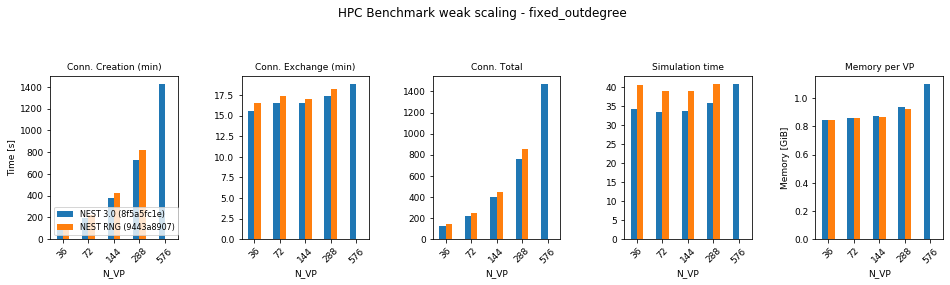

In [24]:
hpc_out_8f = pd.read_csv('results/hpc_benchmark_3_0_8f5a5fc1e_daint_out.csv')
hpc_out_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(hpc_out_8f)

hpc_out_rng = pd.read_csv('results/rng/hpc_benchmark_rng_9443a8907_daint_out.csv')
hpc_out_rng['Case'] = ['NEST RNG (9443a8907)'] * len(hpc_out_rng)

hpc_out = pd.concat([hpc_out_8f, hpc_out_rng])

hpc_out = calculate_T_conn_and_memory(hpc_out)
hpc_out_p = plot_compare(hpc_out, 'figures/rng/hpc_benchmark_weak_scaling_out.png', legend_loc='lower left',
                         title='HPC Benchmark weak scaling - fixed_outdegree')

hpc_out_p

## HPC Benchmark `fixed_total_number` - weak scaling

Conn. Creation (min)                      Conn. Exchange (min)  \
Case NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e)   
N_VP                                                                  
36                  20.95                21.30                20.22   
72                  20.39                21.57                21.19   
144                 20.46                21.67                20.86   
288                 19.75                21.62                22.63   
1152                  NaN                45.80                  NaN   

                                   Conn. Total                       \
Case NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
N_VP                                                                  
36                  20.26                42.63                46.89   
72                  20.32                45.87                45.33   
144                 21.60                45.18                48.00   
288                 23.24                47.25                50.34   
1152                  NaN                  NaN                  NaN   

            Memory per VP                           Simulation time  \
Case NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e)   
N_VP                                                                  
36               0.823975             0.829381                36.83   
72               0.830660             0.831997                32.90   
144              0.849058             0.849175                34.20   
288              0.915606             0.913552                35.93   
1152                  NaN                  NaN                  NaN   

                           
Case NEST RNG (9443a8907)  
N_VP                       
36                  42.15  
72                  38.79  
144                 38.71  
288                 40.92  
1152                  NaN

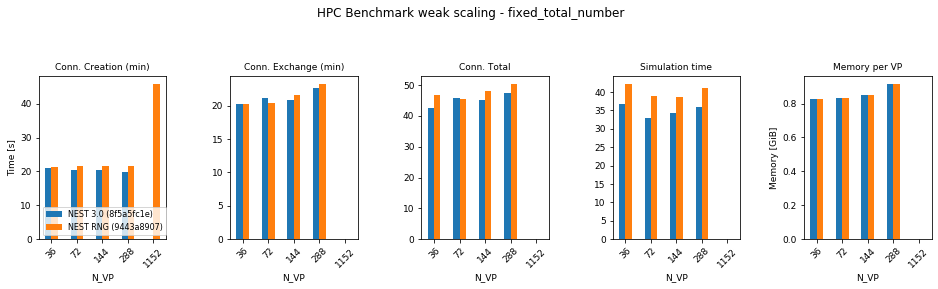

In [25]:
hpc_tot_8f = pd.read_csv('results/hpc_benchmark_3_0_8f5a5fc1e_daint_tot.csv')
hpc_tot_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(hpc_tot_8f)

hpc_tot_rng = pd.read_csv('results/rng/hpc_benchmark_rng_9443a8907_daint_tot.csv')
hpc_tot_rng['Case'] = ['NEST RNG (9443a8907)'] * len(hpc_tot_rng)

hpc_tot = pd.concat([hpc_tot_8f, hpc_tot_rng])

hpc_tot = calculate_T_conn_and_memory(hpc_tot)
hpc_tot_p = plot_compare(hpc_tot, 'figures/rng/hpc_benchmark_weak_scaling_tot.png', legend_loc='lower left',
                         title='HPC Benchmark weak scaling - fixed_total_number')

hpc_tot_p

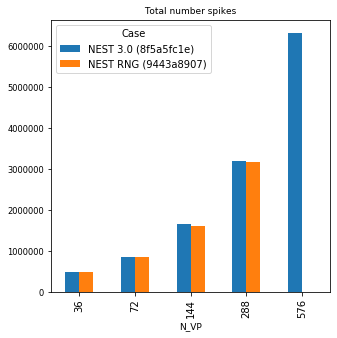

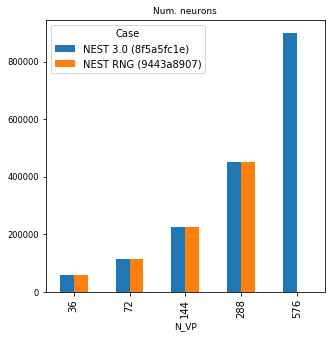

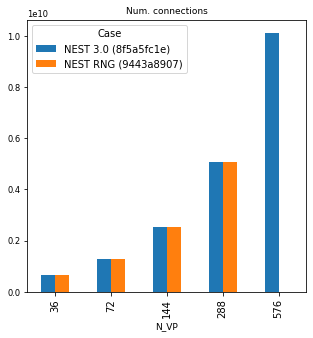

In [8]:
hpc_rule = pd.concat([hpc_out, hpc_tot])

hpc_rule_p = pd.pivot_table(hpc_rule, index='N_VP', columns='Case', values=['N_spks_sum', 'N_nrns', 'N_conns_sum'])

hpc_rule_p['N_spks_sum'].plot(kind='bar', title="Total number spikes", figsize=(5,5))
hpc_rule_p['N_nrns'].plot(kind='bar', title="Num. neurons", figsize=(5,5))
hpc_rule_p['N_conns_sum'].plot(kind='bar', title="Num. connections", figsize=(5,5))

## Python Benchmarks

## Population model - with simulation, weak scaling

Conn. Creation (min)                      Conn. Exchange (min)  \
Case NEST 3.0 (caaf06324) NEST RNG (a4c9117c7) NEST 3.0 (caaf06324)   
N_VP                                                                  
36              40.622820            41.034041            46.986193   
72              60.126592            61.000054            60.685587   
144             78.148904            79.516992            63.240374   
288            113.995589           116.304340            64.878906   
576            188.846742           193.142424            66.013354   
1152           336.423516           344.479789            79.392469   

                                   Conn. Total                       \
Case NEST RNG (a4c9117c7) NEST 3.0 (caaf06324) NEST RNG (a4c9117c7)   
N_VP                                                                  
36              47.188513            97.087072            91.438164   
72              64.699164           131.518319           129.802875   
144             64.559319           152.550738           148.772910   
288             69.900093           190.875659           191.837174   
576             72.521438           267.447102           273.509221   
1152            88.927268           435.651961           447.208726   

            Memory per VP      Simulation time  
Case NEST RNG (a4c9117c7) NEST RNG (a4c9117c7)  
N_VP                                            
36               2.323248            81.674839  
72               3.029288            82.312248  
144              3.112601            81.903779  
288              3.369799           168.727741  
576              3.376890           180.768060  
1152             3.439632           195.475621

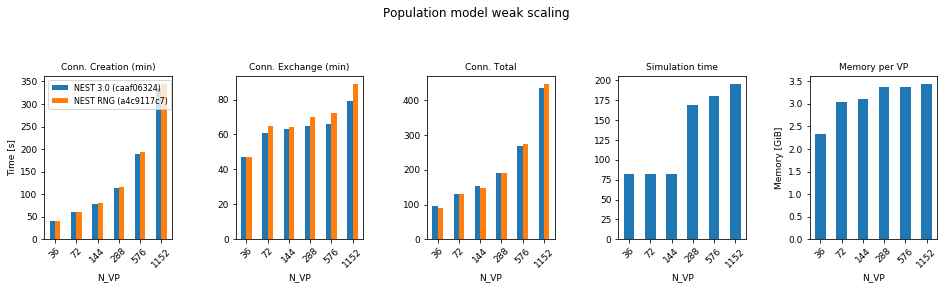

In [24]:
pop_220 = pd.read_csv('results/population_model_2_20_37722d5e3_daint_in_scale4.csv')
pop_220['Case'] = ['NEST 2.20'] * len(pop_220)

pop_3_8f = pd.read_csv('results/population_model_3_0_8f5a5fc1e_daint.csv')
pop_3_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(pop_3_8f)
pop_3_ca = pd.read_csv('results/population_model_3_0_caaf06324_daint.csv')
pop_3_ca['Case'] = ['NEST 3.0 (caaf06324)'] * len(pop_3_ca)

#pop_rng = pd.read_csv('results/rng/population_model_rng_9443a8907_daint.csv')
#pop_rng['Case'] = ['NEST RNG (9443a8907)'] * len(pop_rng)
pop_rng = pd.read_csv('results/rng/population_model_rng_a4c9117c7_daint.csv')
pop_rng['Case'] = ['NEST RNG (a4c9117c7)'] * len(pop_rng)

pop = pd.concat([pop_3_ca, pop_rng])

pop = calculate_T_conn_and_memory(pop)
pop_p = plot_compare(pop, 'figures/rng/population_model_weak_scaling.png', legend_loc='upper left',
                     title='Population model weak scaling')

# print(pop['N_spks_sum'])

pop_p

## Population model - with simulation, strong scaling

Conn. Creation (min)                      Conn. Exchange (min)  \
Case      NEST 3.0 (caaf06324) NEST RNG (9443a8907) NEST 3.0 (caaf06324)   
num_tasks                                                                  
12                   75.094088            88.139236            79.796198   
24                   48.888467            55.578962            39.136030   
48                   35.660502            38.962357            19.986350   
96                   29.538110            31.345915            10.999662   
192                  26.229038            27.369665             5.957565   
384                  24.406173            25.189880             4.368304   
768                  23.213018            23.844734             2.331345   

                                        Conn. Total                       \
Case      NEST RNG (9443a8907) NEST 3.0 (caaf06324) NEST RNG (9443a8907)   
num_tasks                                                                  
12                   76.745035           163.407139           180.555321   
24                   39.500992            94.997510           103.071377   
48                   22.690205            59.317371            66.994738   
96                   12.441035            42.529820            46.630359   
192                   8.582129            33.524474            37.730863   
384                   6.734804            29.900469            33.202596   
768                   4.009909            26.654113            29.077293   

               Memory per task      Simulation time  
Case      NEST RNG (9443a8907) NEST RNG (9443a8907)  
num_tasks                                            
12                   21.824729           102.921283  
24                   12.303752            48.921535  
48                    7.965570            50.323684  
96                    5.396871            39.558214  
192                   4.466074            54.650863  
384                   3.660821            43.173785  
768                   2.833563            32.243013

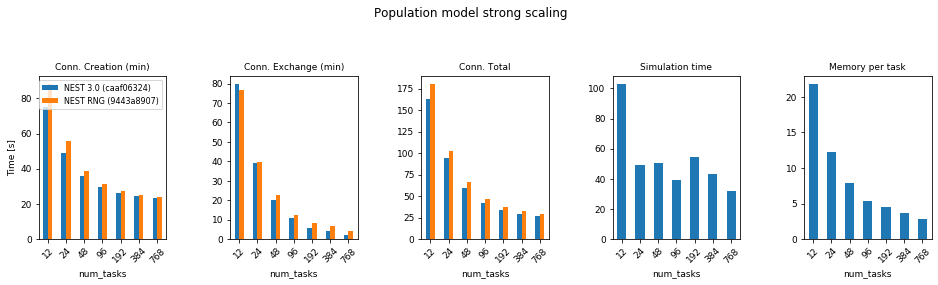

In [39]:
pop_strong_220 = pd.read_csv('results/population_model_2_20_daint_strong_scaling_in.csv')
pop_strong_220['Case'] = ['NEST 2.20'] * len(pop_strong_220)

pop_3_strong_ca = pd.read_csv('results/population_model_3_0_caaf06324_daint_strong_scaling.csv')
pop_3_strong_ca['Case'] = ['NEST 3.0 (caaf06324)'] * len(pop_3_strong_ca)

pop_strong_rng = pd.read_csv('results/rng/population_model_rng_9443a8907_daint_strong_scaling.csv')
pop_strong_rng['Case'] = ['NEST RNG (9443a8907)'] * len(pop_strong_rng)

pop_strong = pd.concat([pop_3_strong_ca, pop_strong_rng])

pop_strong = calculate_T_conn_and_memory(pop_strong)
pop_strong['Memory per task'] = (pop_strong['VSize_sum']/pop_strong['num_tasks'])*1024/1024**3
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
pop_strong_p = plot_compare(pop_strong, 'figures/rng/population_model_strong_scaling.png',
                            values=values, index='num_tasks', plot_T_sim=True,
                            legend_loc='upper right',
                            title='Population model strong scaling')

pop_strong_p

## Multi-Area Model - weak scaling

Conn. Creation (min)                                            \
Case            NEST 2.20 NEST 3.0 (caaf06324) NEST RNG (a4c9117c7)   
N_VP                                                                  
36             104.711977            85.155642           113.068108   
72             146.223853            88.451504           114.396727   
144            231.737406            90.584632           119.453422   
288            406.488460            97.242817           128.165895   
576                   NaN           107.675847           135.377430   
1152                  NaN           123.735972           160.870380   

     Conn. Exchange (min)                                            \
Case            NEST 2.20 NEST 3.0 (caaf06324) NEST RNG (a4c9117c7)   
N_VP                                                                  
36              32.292425            51.528593            50.749163   
72              33.331373            55.906681            53.683483   
144             34.721757            53.544582            51.686072   
288             39.016208            55.109672            55.232999   
576                   NaN            57.848789            55.999160   
1152                  NaN            59.510680            60.079885   

     Conn. Total                                           Memory per VP  \
Case   NEST 2.20 NEST 3.0 (caaf06324) NEST RNG (a4c9117c7)     NEST 2.20   
N_VP                                                                       
36    137.004547           136.684361           163.817335      2.623531   
72    179.555844           144.359141           168.080360      2.662962   
144   266.460711           144.129375           171.139610      2.724151   
288   445.505543           152.352916           183.399098      2.900609   
576          NaN           165.526469           191.376841           NaN   
1152         NaN           183.249203           220.950513           NaN   

                                               Simulation time  \
Case NEST 3.0 (caaf06324) NEST RNG (a4c9117c7)       NEST 2.20   
N_VP                                                             
36               2.663070             2.661147      101.550807   
72               2.738522             2.734592       96.687742   
144              2.801340             2.795769      175.965840   
288              2.902135             2.900565       43.724532   
576              2.718729             2.723710             NaN   
1152             2.958394             2.963435             NaN   

                                                
Case NEST 3.0 (caaf06324) NEST RNG (a4c9117c7)  
N_VP                                            
36             594.216136           675.849802  
72             643.042684           702.850770  
144            304.222491           926.254120  
288            193.938503           282.800807  
576            257.265700           316.260761  
1152           404.681445           444.539528

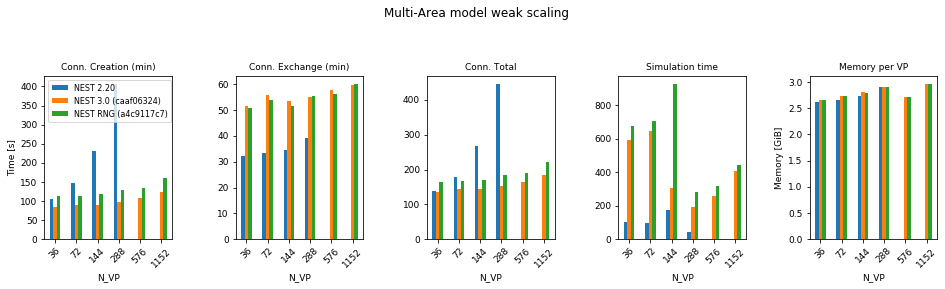

In [36]:
MAM_220 = pd.read_csv('results/multi-area_model_2_20_new_daint.csv')
MAM_220['Case'] = ['NEST 2.20'] * len(MAM_220)

MAM_ca = pd.read_csv('results/multi-area_model_3_caaf06324_daint.csv')
MAM_ca['Case'] = ['NEST 3.0 (caaf06324)'] * len(MAM_ca)
                     
MAM_rng = pd.read_csv('results/rng/multi-area_model_rng_a4c9117c7_daint.csv')
MAM_rng['Case'] = ['NEST RNG (a4c9117c7)'] * len(MAM_rng)

MAM = pd.concat([MAM_220, MAM_ca, MAM_rng])

MAM['T_conns_min'] = MAM['T_network_global_min'] + MAM['T_connect_min']
MAM['T_conns_max'] = MAM['T_network_global_max'] + MAM['T_connect_max']

MAM = calculate_T_conn_and_memory(MAM)
MAM_p = plot_compare(MAM, 'figures/rng/multi-area_model_weak_scaling.png', legend_loc='upper left',
                     title='Multi-Area model weak scaling')
MAM_p

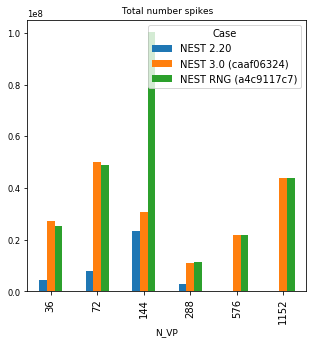

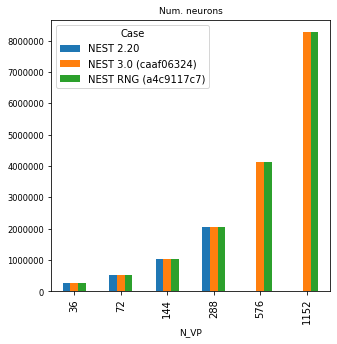

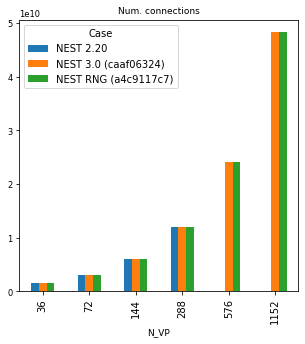

In [37]:
MAM_s = pd.pivot_table(MAM, index='N_VP', columns='Case', values=['N_spks_sum', 'N_nrns', 'N_conns_sum'])

MAM_s['N_spks_sum'].plot(kind='bar', title="Total number spikes", figsize=(5,5))
MAM_s['N_nrns'].plot(kind='bar', title="Num. neurons", figsize=(5,5))
MAM_s['N_conns_sum'].plot(kind='bar', title="Num. connections", figsize=(5,5))

## MAM - strong scaling

Conn. Creation (min)                                            \
Case                 NEST 2.20 NEST 3.0 (caaf06324) NEST RNG (a4c9117c7)   
num_tasks                                                                  
192                 656.739572            72.873003           104.673415   
288                 647.955257            66.617286            99.428660   
384                        NaN                  NaN           100.092630   
480                 642.865273                  NaN           102.287294   
576                 642.099864            59.061144                  NaN   
672                 640.462307            58.321373                  NaN   
768                 640.647660            58.264421                  NaN   

          Conn. Exchange (min)                                            \
Case                 NEST 2.20 NEST 3.0 (caaf06324) NEST RNG (a4c9117c7)   
num_tasks                                                                  
192                  27.460267            30.636053            30.736618   
288                  21.280975            22.073771            22.023038   
384                        NaN                  NaN            18.736170   
480                  15.629361                  NaN            15.903379   
576                  13.862626            16.504207                  NaN   
672                  12.313328            13.234139                  NaN   
768                  11.422459            12.532195                  NaN   

          Conn. Total                                            \
Case        NEST 2.20 NEST 3.0 (caaf06324) NEST RNG (a4c9117c7)   
num_tasks                                                         
192        684.200660           103.510236           135.410175   
288        669.237295            88.691417           121.451882   
384               NaN                  NaN           118.828971   
480        658.496879                  NaN           118.191280   
576        655.966974            75.567345                  NaN   
672        652.782241            71.560800                  NaN   
768        652.083801            70.799140                  NaN   

          Memory per task                                            \
Case            NEST 2.20 NEST 3.0 (caaf06324) NEST RNG (a4c9117c7)   
num_tasks                                                             
192             10.806041            10.340675            10.315874   
288              7.684051             7.338802             7.346567   
384                   NaN                  NaN             6.397777   
480              5.874357                  NaN             5.719232   
576              5.298488             5.145900                  NaN   
672              4.921475             4.757384                  NaN   
768              4.536059             4.473858                  NaN   

          Simulation time                                            
Case            NEST 2.20 NEST 3.0 (caaf06324) NEST RNG (a4c9117c7)  
num_tasks                                                            
192            149.841436           174.418188           208.434433  
288            202.562903           201.468596           229.741548  
384                   NaN                  NaN           182.942421  
480            216.793543                  NaN           198.273193  
576            183.220357           176.377344                  NaN  
672            209.088735           224.446313                  NaN  
768            183.525031           198.862505                  NaN

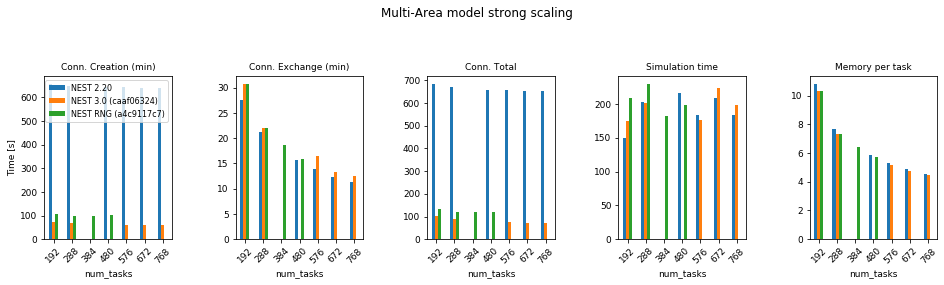

In [38]:
MAM_strong_220 = pd.read_csv('results/multi-area_model_2_20_daint_strong_scaling.csv')
MAM_strong_220['Case'] = ['NEST 2.20'] * len(MAM_strong_220)

MAM_strong_ca = pd.read_csv('results/multi-area_model_3_0_caaf06324_daint_strong_scaling.csv')
MAM_strong_ca['Case'] = ['NEST 3.0 (caaf06324)'] * len(MAM_strong_ca)

MAM_strong_rng = pd.read_csv('results/rng/multi-area_model_rng_a4c9117c7_daint_strong_scaling.csv')
MAM_strong_rng['Case'] = ['NEST RNG (a4c9117c7)'] * len(MAM_strong_rng)

MAM_strong = pd.concat([MAM_strong_220, MAM_strong_ca, MAM_strong_rng])

MAM_strong = calculate_T_conn_and_memory(MAM_strong)
MAM_strong['Memory per task'] = (MAM_strong['VSize_sum']/MAM_strong['num_tasks'])*1024/1024**3
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
MAM_strong_p = plot_compare(MAM_strong, 'figures/rng/multi-area_model_strong_scaling.png',
                            values=values, index='num_tasks', plot_T_sim=True,
                            legend_loc='upper right',
                            title='Multi-Area model strong scaling')

MAM_strong_p

## Hill tonini - Strong scaling

Conn. Creation (min)                                            \
Case                 NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                                  
6                     3.369209             0.538458             0.699559   
12                    2.424937             0.343281             0.416297   
24                    1.863762             0.236212             0.271865   
48                    1.672143                  NaN                  NaN   
96                    1.589094             0.142444                  NaN   
192                   3.329755             0.115095             0.124492   
384                   1.560687             0.103625             0.105825   
768                   3.677774             0.095469             0.099358   

          Conn. Exchange (min)                                            \
Case                 NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                                  
6                     0.344653             0.377994             0.388894   
12                    0.328508             0.422996             0.439749   
24                    0.278032             0.333048             0.330789   
48                    0.188323                  NaN                  NaN   
96                    0.149609             0.225625                  NaN   
192                   0.116746             0.189043             0.219221   
384                   0.129887             0.218439             0.211044   
768                   0.185456             0.318350             0.328166   

          Conn. Total                                            \
Case        NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                         
6            3.853066             0.999555             1.146480   
12           2.901895             0.821878             0.880836   
24           2.281637             0.592714             0.669724   
48           2.019383                  NaN                  NaN   
96           1.900187             0.526999                  NaN   
192          3.600970             0.386075             0.433013   
384          1.859231             0.494050             0.462581   
768          4.055079             0.595469             0.591953   

          Memory per task                                            \
Case            NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                             
6                1.346101             1.985830             1.970062   
12               1.298610             1.930811             1.898035   
24               1.256289             1.887716             1.879395   
48               1.120590                  NaN                  NaN   
96               1.015988             1.718893                  NaN   
192              1.013022             1.685470             1.683965   
384              1.042091             1.712345             1.704873   
768              1.038055             1.707480             1.705924   

          Simulation time                                            
Case            NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)  
num_tasks                                                            
6                1.442217             1.331084             1.331200  
12               0.866928             0.798856             0.741638  
24               0.613624             0.586140             0.601088  
48               0.398614                  NaN                  NaN  
96               0.357492             0.448050                  NaN  
192              0.308830             0.208081             0.227185  
384              0.286875             0.283909             0.295910  
768              0.325538             0.371939             0.370928

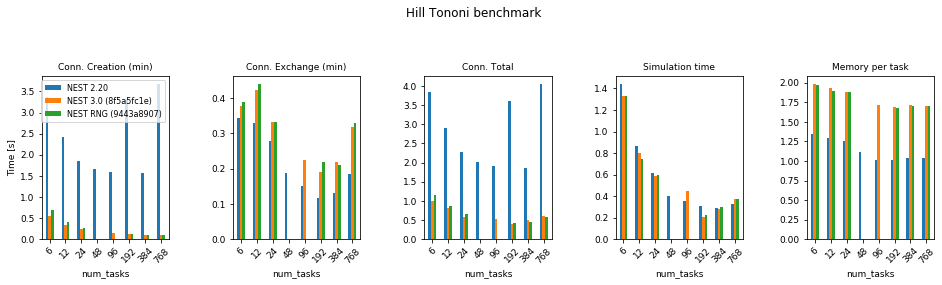

In [34]:
hill_tononi_220 = pd.read_csv('results/hill_tononi_2_20_daint.csv')
hill_tononi_220['Case'] = ['NEST 2.20'] * len(hill_tononi_220)
hill_tononi_3 = pd.read_csv('results/hill_tononi_3_0_0a6bac389_daint.csv')
hill_tononi_3['Case'] = ['NEST 3.0 (0a6bac389)'] * len(hill_tononi_3)

hill_tononi_8f = pd.read_csv('results/hill_tononi_3_0_8f5a5fc1e_daint.csv')
hill_tononi_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(hill_tononi_8f)
hill_tononi_rng = pd.read_csv('results/rng/hill_tononi_9443a8907_daint.csv')
hill_tononi_rng['Case'] = ['NEST RNG (9443a8907)'] * len(hill_tononi_rng)

hill_tononi = pd.concat([hill_tononi_220, hill_tononi_8f, hill_tononi_rng])

hill_tononi = calculate_T_conn_and_memory(hill_tononi)
hill_tononi['Memory per task'] = (hill_tononi['VSize_sum']/hill_tononi['num_tasks'])*1024/1024**3

values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
hill_tononi_p = plot_compare(hill_tononi, 'figures/rng/hill_tononi.png', values=values,
                             index='num_tasks', legend_loc='upper right',
                             title='Hill Tononi benchmark')

hill_tononi_p

# JUSUF BENCHMARKS

## HPC Benchmark - weak scaling

0     2531476000
1     5062951000
2    10125901000
3    20251801000
4    40503601000
5    81007201000
0     2531476000
1     5062951000
2    10125901000
3    20251801000
4    40503601000
5    81007201000
0     2531476000
1     5062951000
2    10125901000
3    20251801000
4    40503601000
5    81007201000
Name: N_conns_sum, dtype: int64

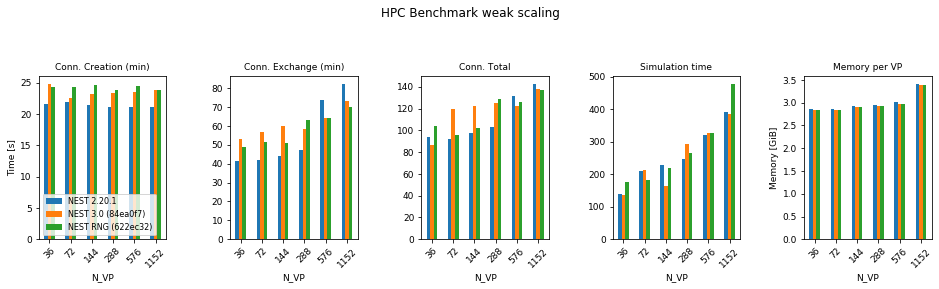

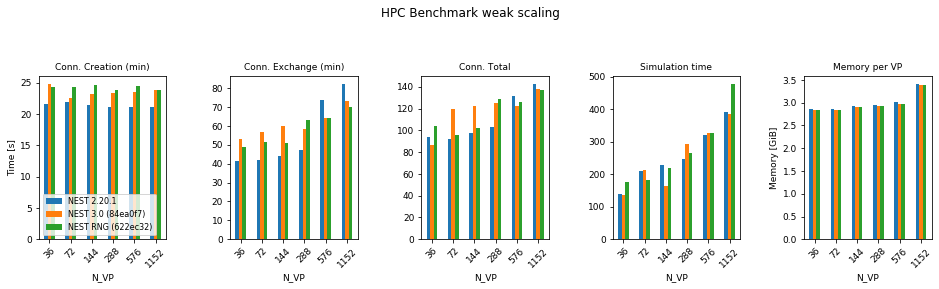

In [6]:
hpc_j_2201 = pd.read_csv('results/jusuf/hpc_benchmark_2_20_1_jusuf.csv')
hpc_j_2201['Case'] = ['NEST 2.20.1'] * len(hpc_j_2201)

hpc_j_3_ca = pd.read_csv('results/jusuf/hpc_benchmark_3_0_84ea0f7_jusuf.csv')
hpc_j_3_ca['Case'] = ['NEST 3.0 (84ea0f7)'] * len(hpc_j_3_ca)

hpc_j_rng = pd.read_csv('results/jusuf/rng/hpc_benchmark_rng_622ec32_jusuf.csv')
hpc_j_rng['Case'] = ['NEST RNG (622ec32)'] * len(hpc_j_rng)

hpc_j = pd.concat([hpc_j_2201, hpc_j_3_ca, hpc_j_rng])

hpc_j = calculate_T_conn_and_memory(hpc_j)
hpc_j_p = plot_compare(hpc_j, 'figures/rng/hpc_benchmark_weak_scaling_jusuf.pdf', legend_loc='lower left',
                       title='HPC Benchmark weak scaling')
hpc_j_p = plot_compare(hpc_j, 'figures/rng/hpc_benchmark_weak_scaling_jusuf.png', legend_loc='lower left',
                       title='HPC Benchmark weak scaling')

hpc_j['N_conns_sum']

## Population model - weak scaling

Conn. Creation (min)                                        \
Case          NEST 2.20.1 NEST 3.0 (84ea0f7) NEST RNG (622ec32)   
N_VP                                                              
36              21.141550          16.444360          16.444360   
72              37.296142          24.210872          24.210872   
144             57.337069          30.614040          30.614040   
288             97.601754          44.833452          44.833452   
576            180.134151          73.876935          73.876935   
1152           343.734149         130.580066         130.580066   

     Conn. Exchange (min)                                       Conn. Total  \
Case          NEST 2.20.1 NEST 3.0 (84ea0f7) NEST RNG (622ec32) NEST 2.20.1   
N_VP                                                                          
36              22.177339          27.704404          27.704404   66.147913   
72              31.581205          45.790164          45.790164  140.759039   
144             37.500896          47.255558          47.255558  182.505319   
288             38.770919          54.013821          54.013821  333.355567   
576             41.548677          58.962035          58.962035  589.953543   
1152            61.372842          82.252202          82.252202  903.462590   

                                           Memory per VP                     \
Case NEST 3.0 (84ea0f7) NEST RNG (622ec32)   NEST 2.20.1 NEST 3.0 (84ea0f7)   
N_VP                                                                          
36            62.075963          62.075963      2.167306           2.151246   
72           115.597597         115.597597      2.915307           2.955866   
144          141.477610         141.477610      3.016064           3.054933   
288          189.559897         189.559897      2.920313           3.190893   
576          292.473973         292.473973      3.010465           3.208395   
1152         490.478411         490.478411      3.009464           3.265512   

                        Simulation time                                        
Case NEST RNG (622ec32)     NEST 2.20.1 NEST 3.0 (84ea0f7) NEST RNG (622ec32)  
N_VP                                                                           
36             2.151246       30.964353          24.212402          24.212402  
72             2.955866       34.150728          79.536642          79.536642  
144            3.054933       48.816164         103.309707         103.309707  
288            3.190893       45.771222         210.660365         210.660365  
576            3.208395       43.462393         261.263314         261.263314  
1152           3.265512       50.114613         344.744568         344.744568

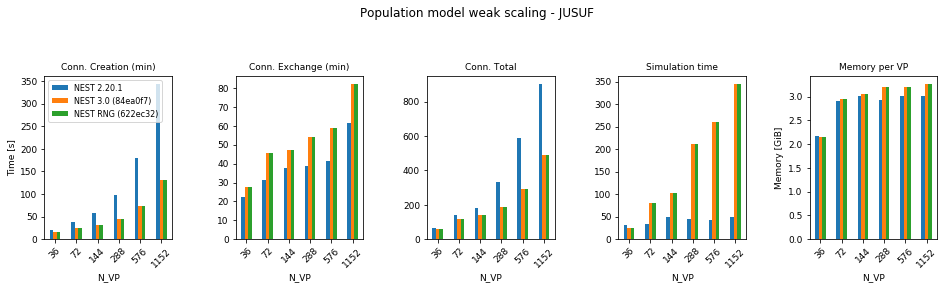

In [15]:
pop_j_2201 = pd.read_csv('results/jusuf/population_model_2_20_1_sim_jusuf.csv')
pop_j_2201['Case'] = ['NEST 2.20.1'] * len(pop_j_2201)

pop_j_3_84 = pd.read_csv('results/jusuf/population_model_3_0_84ea0f7_sim_jusuf.csv')
pop_j_3_84['Case'] = ['NEST 3.0 (84ea0f7)'] * len(pop_j_3_84)

pop_j_rng = pd.read_csv('results/jusuf/rng/population_model_rng_622ec32_sim_jusuf.csv')
pop_j_rng['Case'] = ['NEST RNG (622ec32)'] * len(pop_j_rng)

pop_j = pd.concat([pop_j_2201, pop_j_3_84, pop_j_rng])

pop_j = calculate_T_conn_and_memory(pop_j)
pop_j_p = plot_compare(pop_j, 'figures/rng/population_model_weak_scaling_jusuf.png', legend_loc='upper left',
                       title='Population model weak scaling - JUSUF')

pop_j_p

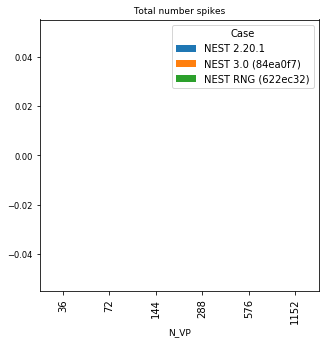

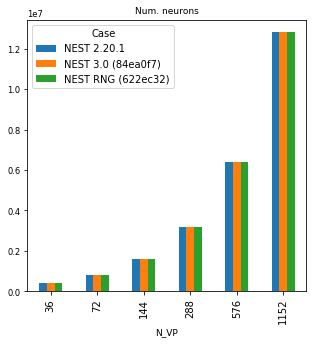

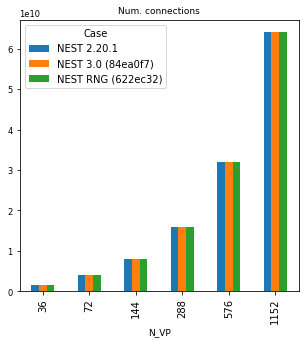

In [13]:
pop_j_s = pd.pivot_table(pop_j, index='N_VP', columns='Case', values=['N_spks_sum', 'N_nrns', 'N_conns_sum'])

pop_j_s['N_spks_sum'].plot(kind='bar', title="Total number spikes", figsize=(5,5))
pop_j_s['N_nrns'].plot(kind='bar', title="Num. neurons", figsize=(5,5))
pop_j_s['N_conns_sum'].plot(kind='bar', title="Num. connections", figsize=(5,5))

## Multi-Area model - weak scaling

Conn. Creation (min)                                        \
Case          NEST 2.20.1 NEST 3.0 (84ea0f7) NEST RNG (622ec32)   
N_VP                                                              
36              58.028205          42.421406          57.949285   
72              67.998503          41.658014          58.057239   
144            103.005810          25.714870          59.867832   
288            171.405990          26.050740          64.670065   
576            312.493823          26.125120          71.238638   
1152           612.651893          28.416013          87.248062   

     Conn. Exchange (min)                                       Conn. Total  \
Case          NEST 2.20.1 NEST 3.0 (84ea0f7) NEST RNG (622ec32) NEST 2.20.1   
N_VP                                                                          
36              25.800741          32.845784          33.463675   83.830068   
72              19.707447           2.000000          37.460404   87.707513   
144             27.587769           1.150558          38.493342  130.596112   
288             30.271936           4.000000          45.828203  201.684071   
576             38.298826           7.976767          60.439738  350.800892   
1152            54.534787           6.000000          68.240501  667.195099   

                                           Memory per VP                     \
Case NEST 3.0 (84ea0f7) NEST RNG (622ec32)   NEST 2.20.1 NEST 3.0 (84ea0f7)   
N_VP                                                                          
36            75.274203          91.413290      2.490952           2.489429   
72            71.591009          95.517892      2.534414           2.522390   
144           61.244885          98.361721      2.584296           2.614624   
288          450.073248         110.498629      2.760934           2.723939   
576           84.457545         131.679419      2.661718           2.568266   
1152          97.178034         155.493710      3.195032           2.894081   

                        Simulation time                                        
Case NEST RNG (622ec32)     NEST 2.20.1 NEST 3.0 (84ea0f7) NEST RNG (622ec32)  
N_VP                                                                           
36             2.489358      431.568564         476.162532         559.036438  
72             2.542991      521.614744         458.495932         943.789790  
144            2.621542      709.615256         521.782069         953.710381  
288            2.734585     1729.604418         616.716611        1442.747994  
576            2.567158     1911.423645        3073.402575        3291.131485  
1152           2.887994     3994.607314        4467.586078        3806.665896

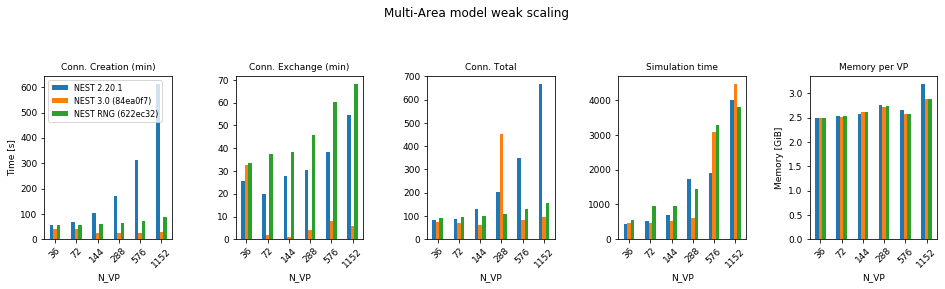

In [9]:
MAM_j_2201 = pd.read_csv('results/jusuf/multi-area_model_2_20_1_jusuf.csv')
MAM_j_2201['Case'] = ['NEST 2.20.1'] * len(MAM_j_2201)

MAM_j_84 = pd.read_csv('results/jusuf/multi-area_model_3_0_84ea0f7_jusuf.csv')
MAM_j_84['Case'] = ['NEST 3.0 (84ea0f7)'] * len(MAM_j_84)
                     
MAM_j_rng = pd.read_csv('results/jusuf/rng/multi-area_model_rng_622ec32_jusuf.csv')
MAM_j_rng['Case'] = ['NEST RNG (622ec32)'] * len(MAM_j_rng)

MAM_j = pd.concat([MAM_j_2201, MAM_j_84, MAM_j_rng])

MAM_j['T_conns_min'] = MAM_j['T_network_global_min'] + MAM_j['T_connect_min']
MAM_j['T_conns_max'] = MAM_j['T_network_global_max'] + MAM_j['T_connect_max']

MAM_j = calculate_T_conn_and_memory(MAM_j)
MAM_j_p = plot_compare(MAM_j, 'figures/rng/multi-area_model_weak_scaling_jusuf.png', legend_loc='upper left',
                       title='Multi-Area model weak scaling')
MAM_j_p

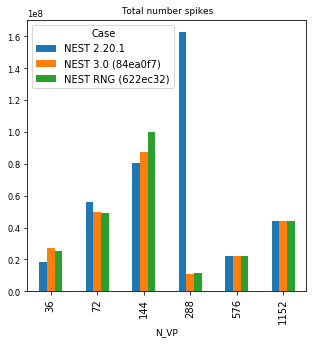

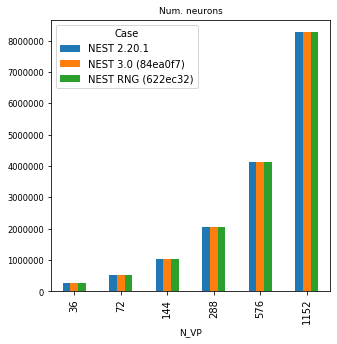

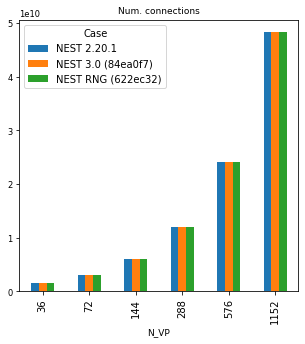

In [10]:
MAM_j_s = pd.pivot_table(MAM_j, index='N_VP', columns='Case', values=['N_spks_sum', 'N_nrns', 'N_conns_sum'])

MAM_j_s['N_spks_sum'].plot(kind='bar', title="Total number spikes", figsize=(5,5))
MAM_j_s['N_nrns'].plot(kind='bar', title="Num. neurons", figsize=(5,5))
MAM_j_s['N_conns_sum'].plot(kind='bar', title="Num. connections", figsize=(5,5))

## Hill-Tononi - strong scaling

Conn. Creation (min)                                        \
Case               NEST 2.20.1 NEST 3.0 (84ea0f7) NEST RNG (622ec32)   
num_tasks                                                              
6                     3.601288           0.356162           0.355901   
12                    1.839070           0.163592           0.249626   
24                    2.119406           0.108972           0.132833   
48                    1.750610           0.093653           0.095237   
96                    1.618644           0.068794           0.074387   
192                        NaN           0.063692           0.066030   
384                   1.606209           0.057321           0.057807   

          Conn. Exchange (min)                                        \
Case               NEST 2.20.1 NEST 3.0 (84ea0f7) NEST RNG (622ec32)   
num_tasks                                                              
6                     0.310220           0.611066           0.655143   
12                    0.675162           1.309150           1.488444   
24                    1.783848           1.081987           1.637836   
48                    2.332352           1.463554           2.643314   
96                    2.135020           1.803531           2.531196   
192                        NaN           1.339537           1.691018   
384                   3.154144           3.250572           3.532265   

          Conn. Total                                       Memory per task  \
Case      NEST 2.20.1 NEST 3.0 (84ea0f7) NEST RNG (622ec32)     NEST 2.20.1   
num_tasks                                                                     
6            4.006355           1.430578           1.821917        0.931667   
12           2.650660           1.812721           2.290718        0.935659   
24           4.011673           1.410095           2.036511        0.923391   
48           4.250699           1.721862           2.935628        0.909465   
96           3.864069           2.019075           2.760751        0.917252   
192               NaN           1.536927           1.895798             NaN   
384          4.842325           3.446526           3.733601        0.962367   

                                                Simulation time  \
Case      NEST 3.0 (84ea0f7) NEST RNG (622ec32)     NEST 2.20.1   
num_tasks                                                         
6                   1.010096           0.994914        2.596585   
12                  1.018808           0.978642        3.877153   
24                  0.973235           0.979618        9.592022   
48                  0.998564           0.987858       19.826279   
96                  1.003234           0.998061       23.883929   
192                 0.968486           0.985175             NaN   
384                 1.021006           1.041069        1.980757   

                                                 
Case      NEST 3.0 (84ea0f7) NEST RNG (622ec32)  
num_tasks                                        
6                   4.056400           3.956371  
12                  6.560357           6.004112  
24                  4.936267           8.524852  
48                 11.467522          18.389388  
96                 23.104588          23.855724  
192                 2.019114           2.157780  
384                 2.102968           2.256839

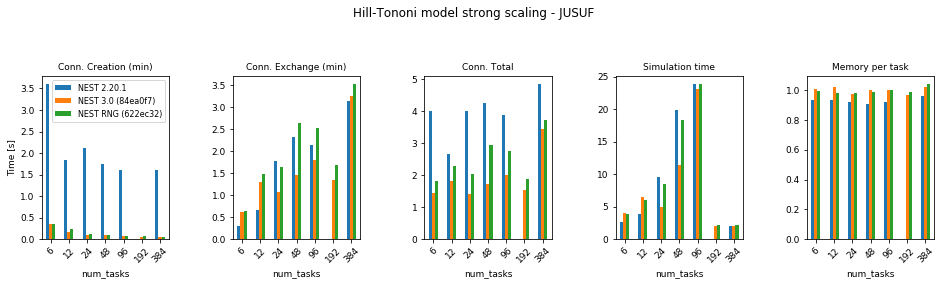

In [39]:
hill_j_2201 = pd.read_csv('results/jusuf/hill_tononi_2_20_1_jusuf.csv')
hill_j_2201['Case'] = ['NEST 2.20.1'] * len(hill_j_2201)

hill_j_84 = pd.read_csv('results/jusuf/hill_tononi_3_0_84ea0f7_jusuf.csv')
hill_j_84['Case'] = ['NEST 3.0 (84ea0f7)'] * len(hill_j_84)
                     
hill_j_rng = pd.read_csv('results/jusuf/rng/hill_tononi_rng_622ec32_jusuf.csv')
hill_j_rng['Case'] = ['NEST RNG (622ec32)'] * len(hill_j_rng)

hill_j = pd.concat([hill_j_2201, hill_j_84, hill_j_rng])

hill_j = calculate_T_conn_and_memory(hill_j)

hill_j['Memory per task'] = (hill_j['VSize_sum']/hill_j['num_tasks'])*1024/1024**3
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']

hill_j_p = plot_compare(hill_j, 'figures/rng/hill-tononi_model_strong_scaling_jusuf.png', values=values,
                        index='num_tasks', legend_loc='upper right',
                        title='Hill-Tononi model strong scaling - JUSUF')

hill_j_p

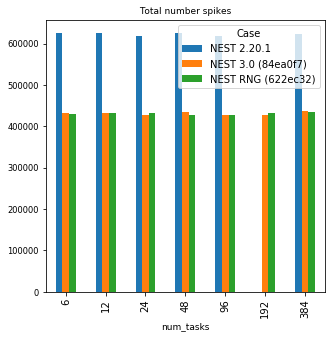

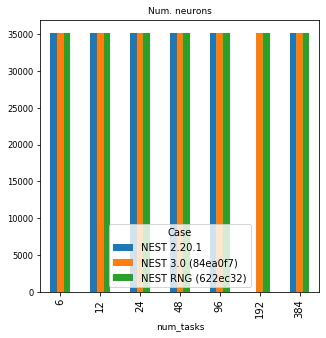

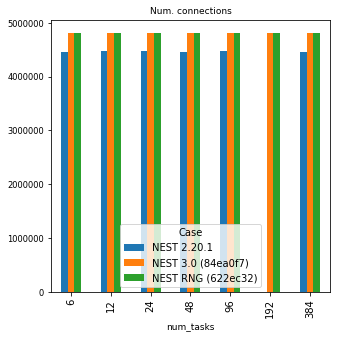

In [41]:
hill_j_s = pd.pivot_table(hill_j, index='num_tasks', columns='Case',
                          values=['N_spks_sum', 'N_nrns', 'N_conns_sum'])

hill_j_s['N_spks_sum'].plot(kind='bar', title="Total number spikes", figsize=(5,5))
hill_j_s['N_nrns'].plot(kind='bar', title="Num. neurons", figsize=(5,5))
hill_j_s['N_conns_sum'].plot(kind='bar', title="Num. connections", figsize=(5,5))